In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

In [90]:
N_EPOCHS = 2    # number of epochs of training
BATCH_SIZE = 50   # size of the batches
LR = 1e-5         # adam: learning rate
B1 = 0.5          # adam: decay of first order momentum of gradient
B2 = 0.999        # adam: decay of first order momentum of gradient

N_CPU = 11         # number of cpu threads to use during batch generation
LATENT_DIM = 100  # dimensionality of the latent space
IMG_SIZE = 28     # size of each image dimension
CHANNELS = 1      # number of image channels
SAMPLE_INTERVAL = 100 # interval betwen image samples

In [91]:
img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)
torch.manual_seed(12345)
cuda = True if torch.cuda.is_available() else False
print("CUDA:", cuda)

CUDA: False


In [92]:
class Unconv2d(nn.Module):
    def __init__(self, in_channels, kernel_channels, kernel_size, input_size, bias=True):
        super().__init__()
        
        self.in_channels = in_channels
        self.kernel_channels = kernel_channels
        self.kernel_size = kernel_size
        self.input_size = input_size
        
        self.weight = nn.Parameter(
            torch.Tensor(1, in_channels * kernel_channels, *input_size, *kernel_size),
        )
        if bias:
            self.bias = nn.Parameter(
                torch.Tensor(1, in_channels * kernel_channels, *input_size, *kernel_size),
            )
        else:
            self.register_parameter('bias', None)   
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)
            
    def extra_repr(self):
        return "in_channels={}, kernel_channels={}, bias={}".format(
            self.in_channels, self.kernel_channels, self.bias is not None
        ) + "kernel_size={}, input_size={}".format(self.kernel_size, self.input_size) 
        
    def forward(self, input_):
        input_ = input_.repeat(1, self.kernel_channels, 1, 1, 1, 1)
        unbiased = torch.mul(self.weight, input_)
        if self.bias is None:
            return unbiased
        output = torch.add(self.bias, unbiased)
        return output
    
unc = Unconv2d(10, 20, (4, 4), (7, 7), bias=False)
t = torch.randn(10, 7, 7, 1, 1)
unc(t).shape

torch.Size([1, 200, 7, 7, 4, 4])

In [ ]:
class WeightedImage(nn.Module):
    def __init__(self, in_channels, bias=True):
        super().__init__()
        
        self.in_channels = in_channels
        
        self.weight = nn.Parameter(
            torch.Tensor(1, in_channels, 1, 1),
        )
        if bias:
            self.bias = nn.Parameter(
                torch.Tensor(1, in_channels, 1, 1),
            )
        else:
            self.register_parameter('bias', None)   
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)
            
    def extra_repr(self):
        return "in_channels={}, bias={}".format(
            self.in_channels, self.bias is not None
        )
        
    def forward(self, input_):
        unbiased = torch.mul(self.weight, input_)
        if self.bias is None:
            return unbiased
        output = torch.add(self.bias, unbiased)
        return output


In [143]:
class Generator(nn.Module):
    def __init__(self,
                 inner_fc_size=128,
                 small_imag_size=(7, 7),
                 small_channels=64,
                 big_imag_kernel_size=(4, 4),
                 big_imag_kernel_channels=2                 
                ):
        super().__init__()
        self.inner_fc_size = inner_fc_size
        self.small_imag_size = small_imag_size
        self.small_channels = small_channels
        self.big_imag_kernel_size = big_imag_kernel_size
        self.big_imag_kernel_channels = big_imag_kernel_channels        
        
        self.fc1 = nn.Linear(LATENT_DIM, inner_fc_size)
        self.fc2 = nn.Linear(
            inner_fc_size, 
            small_imag_size[0] * small_imag_size[1] * small_channels
        )
        self.unconv = Unconv2d(
            small_channels, big_imag_kernel_channels, big_imag_kernel_size, small_imag_size
        )
        self.weim = WeightedImage(small_channels * big_imag_kernel_channels)
        
    
    def tt(self, m, n, i, j):
        t1 = torch.arange(0, m * n, i * j).view(int(m / i), int(n / j)).repeat_interleave(i, dim=0).repeat_interleave(j, dim=1)
        t2 = torch.arange(i * j).view(i, j).repeat(int(m / i), int(n / j))
        return (t1 + t2).view(m * n)
        
    def forward(self, z):
        flat_z = F.leaky_relu(self.fc1(z), 0.2)
        flat_z = F.leaky_relu(self.fc2(flat_z), 0.2)
        
        small_imgs = flat_z.view(
            BATCH_SIZE, 
            self.small_channels, 
            *self.small_imag_size, 
            1, 1
        )
        
        big_imgs = self.unconv(small_imgs)  
        big_imgs = big_imgs.view(
            BATCH_SIZE, 
            self.small_channels * self.big_imag_kernel_channels, 
            IMG_SIZE * IMG_SIZE
        ).transpose(0, -1)
        big_imgs = big_imgs[
            self.tt(IMG_SIZE, IMG_SIZE, *self.big_imag_kernel_size)
        ].transpose(0, -1)
        big_imgs = F.leaky_relu(big_imgs.view(
            BATCH_SIZE, 
            self.small_channels * self.big_imag_kernel_channels, 
            IMG_SIZE, 
            IMG_SIZE
        ), 0.2)
        
        weighted_img = self.weim(big_imgs)
#         weighted_img = F.softmax(torch.sum(weighted_img, dim=1))
        weighted_img = torch.tanh(torch.sum(weighted_img, dim=1))
    
        return weighted_img.view(weighted_img.size(0), *img_shape)
        
        

In [144]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
#         print("validity:\n", validity)
#         print(validity.shape)
        return validity

In [145]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [146]:
# Configure data loader
# os.makedirs("../PyTorch/MNIST", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.Resize(IMG_SIZE), 
                transforms.ToTensor(), 
                transforms.Normalize([0.5], [0.5])
            ]
        ),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [147]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(B1, B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(B1, B2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

gen_imgs:  torch.Size([50, 1, 28, 28])


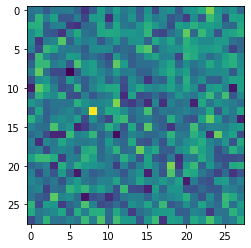

In [148]:
z = Variable(Tensor(np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))))

generator = Generator()
gen_imgs = generator(z)
plt.imshow(gen_imgs[0][0].detach().numpy())
print("gen_imgs: ", gen_imgs.size())

In [149]:
for epoch in range(N_EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], LATENT_DIM))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i
        if batches_done % SAMPLE_INTERVAL == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
            print(
                "[Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (batches_done, len(dataloader)*N_EPOCHS, d_loss.item(), g_loss.item())
            ) 
    print(
            "--- [Epoch %d/%d] [D loss: %f] [G loss: %f] ---"
            % (epoch, N_EPOCHS, d_loss.item(), g_loss.item())
        )

[Batch 0/2400] [D loss: 0.680889] [G loss: 0.692658]
[Batch 100/2400] [D loss: 0.482982] [G loss: 0.655844]


KeyboardInterrupt: 

In [ ]:
plt.imshow(gen_imgs[0][0].detach().numpy())